In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import sympy as sp
import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline

# 忽略所有警告
import warnings
warnings.simplefilter("ignore")

# 7.1

In [2]:
class MetropolisHastings():
    def __init__(self) -> None:
        self.mu1, self.mu2 = 7, 10
        self.sigma1, self.sigma2 = 0.5**2, 0.5**2

    def DeltaPrior(self, delta):
        return np.logical_and(delta>=0, delta<1).astype(np.float32)
    
    def RandomWalk(self, delta_known, eps_low = -1, eps_up = 1, random_generator = None, U_space = False):
        if(U_space):
            upper_lim = delta_known + eps_up
            lower_lim = delta_known + eps_low
        else:
            upper_lim = min(delta_known + eps_up, 1)
            lower_lim = max(0, delta_known + eps_low)
        if(random_generator is None):
            new_delta = np.random.uniform(lower_lim, upper_lim, size = 1)
        else:
            new_delta = random_generator.uniform(lower_lim, upper_lim, size = 1)
        return new_delta

    def RandomWalkProb(self, delta, delta_known, eps_low = -1, eps_up = 1, U_space = False):
        if(U_space):
            upper_lim = delta_known + eps_up
            lower_lim = delta_known + eps_low
        else:
            upper_lim = min(delta_known + eps_up, 1)
            lower_lim = max(0, delta_known + eps_low)
        prob = 1/(upper_lim - lower_lim)
        return prob
    
    def DeltaProb(self, delta, data, mu1 = 7, mu2 = 10, sigma1 = 0.5**2, sigma2 = 0.5**2):
        part1 = delta*1/np.sqrt(sigma1*2*np.pi)*np.exp(-1/2*(data-mu1)**2/sigma1)
        part2 = (1-delta)*1/np.sqrt(sigma2*2*np.pi)*np.exp(-1/2*(data-mu2)**2/sigma2)
        prob = np.prod(part1 + part2)

        return prob

    def MixedNormSampling(self, num_distribution = 2, mus = np.array([7, 10]), sigmas = np.array([0.5**2, 0.5**2]), ratios = np.array([0.7, 1-0.7]), sample_size = 200, seed = 1024, is_plot = False):
        mus, sigmas, ratios = np.array(mus), np.array(sigmas), np.array(ratios)
        ratios = ratios/np.sum(ratios)

        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)

        U = rng.uniform(0, 1, sample_size)
        idxs = []
        sampling = np.zeros(sample_size)
        for i in range(num_distribution):
            lower = 0 + np.sum(ratios[:i])
            upper = 1 - np.sum(ratios[i+1:])
            idxs.append(np.where(np.logical_and(U >= lower, U < upper)))
            sampling[idxs[i]] = rng.normal(loc = mus[i], scale = sigmas[i], size = idxs[i][0].shape[0])
        if(is_plot):
            fig = plt.figure(figsize = (10, 5))
            bin_width = np.min(sigmas)/2
            sns.distplot(sampling, bins=np.arange(min(sampling), max(sampling) + bin_width, bin_width))
            fig.show()

        return sampling
    
    def Independencechain(self, data, num_iteration = 10000, seed = 1024, is_plot = False):
        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)

        delta = 0
        list_delta = []
        for t in range(num_iteration):
            tmp_delta = rng.uniform(0, 1, size = 1)
            R = min(1, self.DeltaProb(tmp_delta, data)/self.DeltaProb(delta, data)*self.DeltaPrior(delta)/self.DeltaPrior(tmp_delta))
            u = rng.uniform(0, 1, size = 1)
            if(u < R):
                delta = tmp_delta
            else:
                delta = delta
            list_delta.append(delta)
        list_delta = np.array(list_delta).reshape(-1)

        if(is_plot):
            fig = plt.figure(figsize = (15, 5))
            plt.title("Sample path of delta using independence chain MCMC")
            plt.plot(list_delta, "-", label = "delta")
            plt.xlabel("t")
            plt.ylabel("delta")
            plt.legend()
            fig.show()

        return list_delta
    
    def RandomWalkChain(self, data, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, U_space = False, is_plot = False):
        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)

        delta = 0
        list_delta = []
        if(U_space):
            U = 0
            delta = 1/(np.exp(-U) + 1)
            jacob = np.exp(-U)*delta**2
            for t in range(num_iteration):
                tmp_U = self.RandomWalk(U, eps_lower, eps_upper, rng, U_space)
                tmp_delta = 1/(np.exp(-tmp_U) + 1)
                tmp_jacob = np.exp(-tmp_U)*tmp_delta**2
                R = min(1, self.DeltaProb(tmp_delta, data)/self.DeltaProb(delta, data))*self.RandomWalkProb(U, tmp_U, eps_lower, eps_upper, U_space)/self.RandomWalkProb(tmp_U, U, eps_lower, eps_upper, U_space)*jacob/tmp_jacob
                u = rng.uniform(0, 1, size = 1)
                if(u < R):
                    U = tmp_U
                    delta = tmp_delta
                    jacob = tmp_jacob
                list_delta.append(delta)
        else:
            for t in range(num_iteration):
                tmp_delta = self.RandomWalk(delta, eps_lower, eps_upper, rng)
                R = min(1, self.DeltaProb(tmp_delta, data)/self.DeltaProb(delta, data))*self.RandomWalkProb(delta, tmp_delta, eps_lower, eps_upper)/self.RandomWalkProb(tmp_delta, delta, eps_lower, eps_upper)
                u = rng.uniform(0, 1, size = 1)
                if(u < R):
                    delta = tmp_delta
                list_delta.append(delta)

        list_delta = np.array(list_delta).reshape(-1)

        if(is_plot):
            fig = plt.figure(figsize = (15, 5))
            plt.title("Sample path of delta using random walk chain MCMC")
            label_ = "Random walk step ~ U(%.2f, %.2f)"%(eps_lower, eps_upper)
            if(U_space):
                label_ += " in U space"
            plt.plot(list_delta, "-", label = label_)
            plt.xlabel("t")
            plt.ylabel("delta")
            plt.legend()
            fig.show()

        return list_delta

    def PlotCompare(self):
        names = ["ID Chain", "RW(-1, 1) delta", "RW(-0.01, 0.01) delta", "RW(-1, 1) U", "RW(-0.01, 0.01) U"]
        mixed_norm_sample = self.MixedNormSampling(num_distribution = 2, mus = [7, 10], sigmas = [0.5**2, 0.5**2], ratios = [0.7, 1-0.7], sample_size = 200, seed = 1024, is_plot = False)
        independence_chain_deltaMC = self.Independencechain(mixed_norm_sample, num_iteration = 10000, seed = 1024, is_plot = False)
        randomwalk_chain_deltaMC1 = self.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, is_plot = False)
        randomwalk_chain_deltaMC2 = self.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -0.01, eps_upper = 0.01, is_plot = False)
        randomwalk_chain_deltaMC3 = self.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, is_plot = False, U_space =  True)
        randomwalk_chain_deltaMC4 = self.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -0.01, eps_upper = 0.01, is_plot = False, U_space =  True)
        results = np.array([independence_chain_deltaMC, randomwalk_chain_deltaMC1, randomwalk_chain_deltaMC2, randomwalk_chain_deltaMC3, randomwalk_chain_deltaMC4])

        fig = plt.figure(figsize = (10, 5))
        plt.boxplot(results.T)
        plt.xticks(range(1, len(names) + 1), names)
        fig.show()


In [3]:
mh = MetropolisHastings()

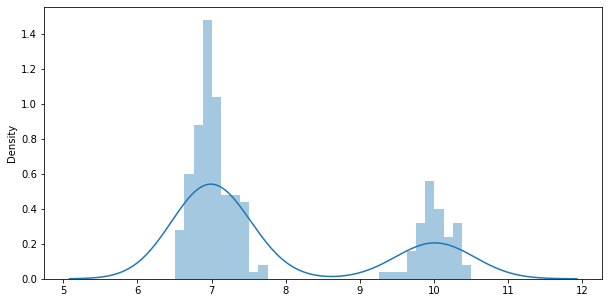

In [4]:
mixed_norm_sample = mh.MixedNormSampling(num_distribution = 2, mus = [7, 10], sigmas = [0.5**2, 0.5**2], ratios = [0.7, 1-0.7], sample_size = 200, seed = 1024, is_plot = True)

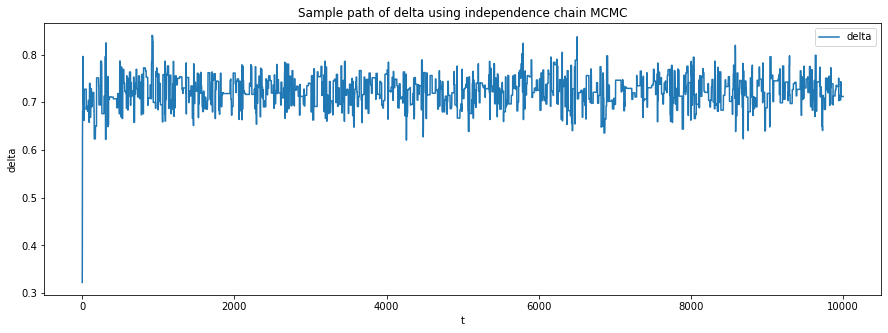

In [5]:
independence_chain_deltaMC = mh.Independencechain(mixed_norm_sample, num_iteration = 10000, seed = 1024, is_plot = True)

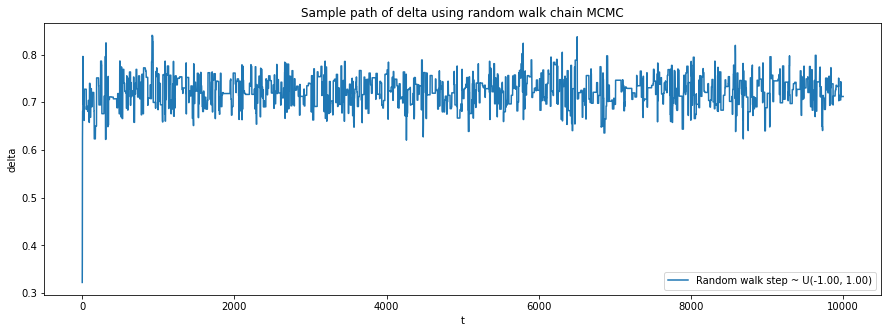

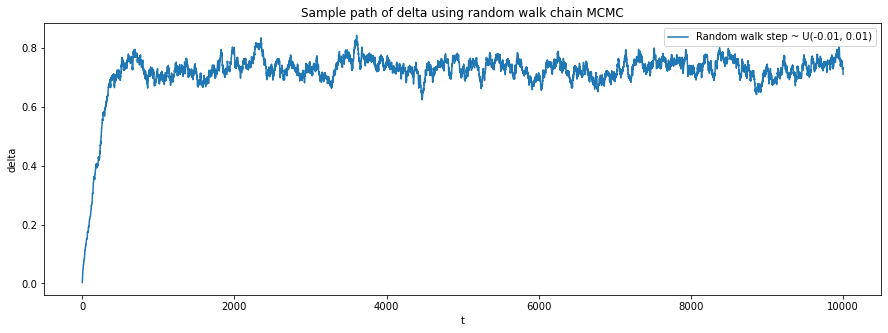

In [6]:
randomwalk_chain_deltaMC1 = mh.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, is_plot = True)
randomwalk_chain_deltaMC2 = mh.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -0.01, eps_upper = 0.01, is_plot = True)

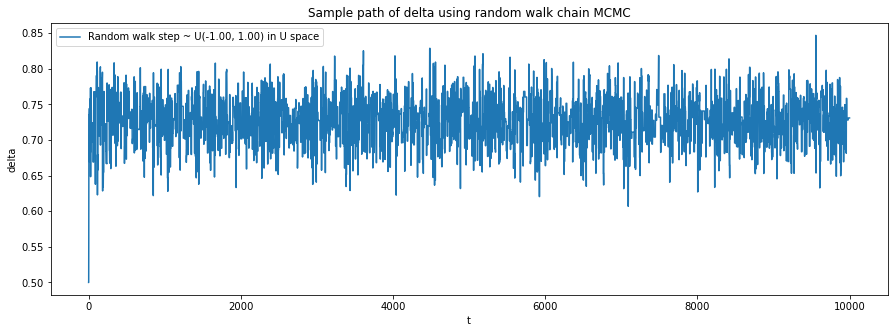

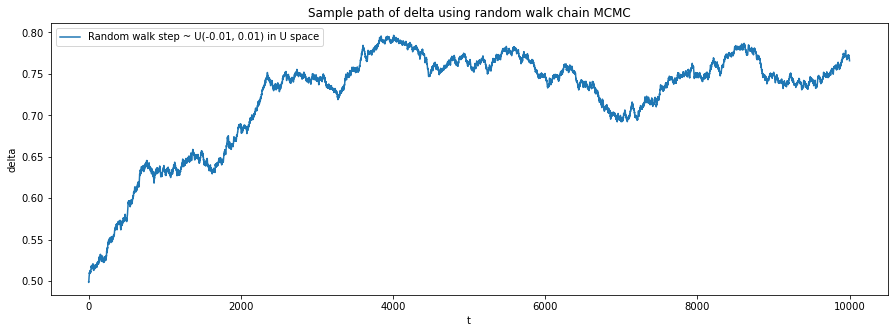

In [7]:
randomwalk_chain_deltaMC3 = mh.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -1, eps_upper = 1, is_plot = True, U_space =  True)
randomwalk_chain_deltaMC4 = mh.RandomWalkChain(mixed_norm_sample, num_iteration = 10000, seed = 1024, eps_lower = -0.01, eps_upper = 0.01, is_plot = True, U_space =  True)

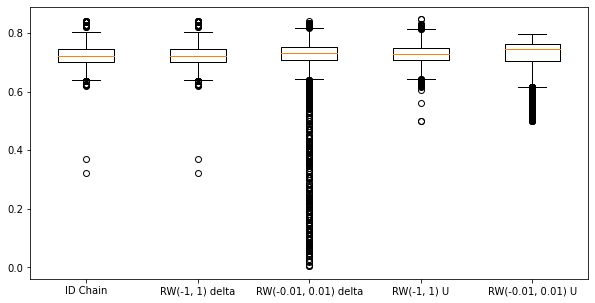

In [8]:
mh.PlotCompare()